<a href="https://colab.research.google.com/github/vbanai/ML-Technics-in-Sales-and-Marketing/blob/main/Sentiment_Analysis_Hotel_Reviews.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

SENTIMENT ANALYSIS<br/>
<br/>
Sentiment Analysis is the most common text classification method that analyses an <br/>incoming message and tells whether the underlying sentiment is positive, <br/>or negative. The data I am analyzing is downloaded from Kaggel and having <br/>been scraped from Booking.com.  This dataset contains 515,000<br/> customer reviews and scoring of 1493 luxury hotels across Europe.

In [ ]:
import os
!pip install -U scikit-learn

os.environ['KAGGLE_USERNAME'] = "viktorbanai" # username from the json file
os.environ['KAGGLE_KEY'] = "9431db56af1a1a63cab88b4e516a2248" # key from the json file
!kaggle datasets download -d jiashenliu/515k-hotel-reviews-data-in-europe # api copied from kaggle

!mkdir file_destination_booking
!unzip -u "/content/515k-hotel-reviews-data-in-europe.zip" -d "/content/file_destination_booking"



Explore the dataset

In [ ]:
import pandas as pd
df_initial = pd.read_csv("/content/file_destination_booking/Hotel_Reviews.csv")

df_initial["review"] = df_initial["Negative_Review"] + df_initial["Positive_Review"]
df_initial["is_good_review"] = df_initial["Reviewer_Score"].apply(lambda x: 0 if x < 5 else 1)
df_initial = df_initial[["review", "is_good_review"]]
df_initial.isnull().values.any()

False

In [ ]:
df_initial["text"]=df_initial["is_good_review"].apply(lambda x: "Good review" if x == 1 else "Bad review")

sentiment_count=df_initial["text"].value_counts()
sentiment_count

Good review    493457
Bad review      22281
Name: text, dtype: int64

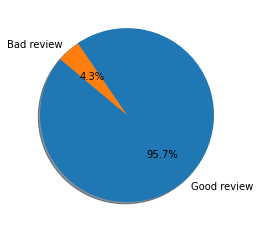

In [ ]:

import matplotlib.pyplot as plt
plt.pie(sentiment_count, labels=sentiment_count.index, autopct='%1.1f%%', shadow=True, startangle=140)
plt.show()

Highlight some words in the positive comments

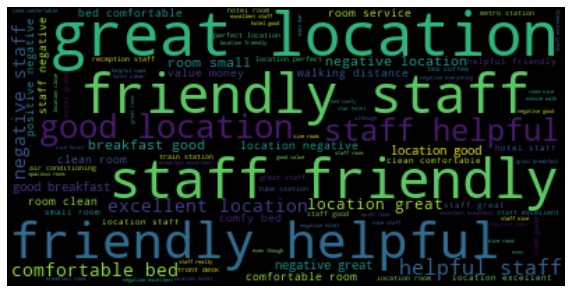

In [ ]:
from wordcloud import WordCloud
pos_booking=df_initial[df_initial["is_good_review"]==1]
txt=" ".join(x.lower() for x in pos_booking["review"])
wordcloud=WordCloud().generate(txt)
plt.rcParams["figure.figsize"] = (10,8)
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.show()

Highlight some words in the negative comments

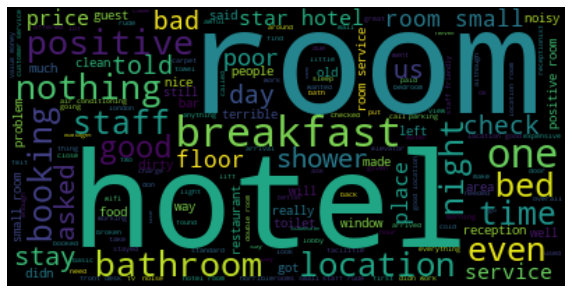

In [ ]:
from wordcloud import WordCloud
pos_booking=df_initial[df_initial["is_good_review"]==0]
txt=" ".join(x.lower() for x in pos_booking["review"])
wordcloud=WordCloud().generate(txt)
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.show()

Text Normalization

Remove those part of the sentences which don't contain useful meaning</br>
I will choose some elements arbitrary that are to be remove. Actually this</br>
text has alreay been normalized by the owner more or less.

In [ ]:
import re #regex
!pip install emoji --upgrade
import emoji

#Test the normalization on a text
text="Answer @Vaersgo I like it! 😊 https_//Vaersgo.hu #Splendid #Fun"

#replace Reply
def replace_reply(text, default_replace=""):
  text = re.sub('Answer\s+', default_replace, text)  #replace "Answer" with default_replace, \s:white space,
  return text

text_altered=replace_reply(text)

def replace_user(text, default_replace="user"):
  text=re.sub('\B@\w+',default_replace, text)   #\w: means any word item can follow @, \B: just when @ is in the beginnig of an expression, leave alone the email address in this way
  return text

text_altered2=replace_user(text_altered)

def demojize(text):
  text= emoji.demojize(text)
  return text

text_altered3=demojize(text_altered2)

def replace_url(text, default_replace=""):
  text=re.sub(r'(https|http)\S+', default_replace, text) #| vertical slash= or, S+ means everything after http\\:
  return text

text_altered4=replace_url(text_altered3)

def replace_hashtag(text, default_replace=""):
  text=re.sub('#+', default_replace, text)
  return text

text_altered5=replace_hashtag(text_altered4)
text_altered5

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 240.9/240.9 KB 10.0 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for emoji: filename=emoji-2.2.0-py3-none-any.whl size=234926 sha256=dc495c69beb8cbd4ce58aea6237f86beaa49eeef37dae96950197f77bbdb93e6
  Stored in directory: /root/.cache/pip/wheels/86/62/9e/a6b27a681abcde69970dbc0326ff51955f3beac72f15696984
Successfully built emoji


'user I like it! :smiling_face_with_smiling_eyes:  Splendid Fun'

In [ ]:
# test some other cleaning technics
!pip install contractions

import contractions
print(contractions.contractions_dict)

text="LOOOOOOOK at this ... I'd do my best!"
def to_lowercase(text):
  text=text.lower()
  return text

altered=to_lowercase(text)

def word_repetition(text):
  text=re.sub(r'(.)\1+', r'\1\1', text)   #(.)\1+= repetions capture, r'\1\1 first replace the capturing, second replace the mach with one + single occurence
  return text

altered2=word_repetition(altered)

def punct_repetition(text, default_replace=""):
  text=re.sub(r'[\?\.\!]+(?=[\?\.\!])', default_replace, text) #choosing the punct: r'[\?\.\!], keep the last punct  ?=[\?\.\!]
  return text

altered3=punct_repetition(altered2)

#best method for constructions
def fix_contractions(text):
  text=contractions.fix(text)
  return text

fix_contractions(altered3)

Tokenization

In [ ]:
!pip install nltk

import nltk
from nltk.tokenize import word_tokenize
nltk.download('punkt')

text= "These are the 4 best things!"

def tokenize(text):
  tokens=word_tokenize(text)
  return tokens

print(type(tokenize(text)))
print("Text tokens:{}".format(tokenize(text)))

from nltk.corpus import stopwords  #stopword has no special meanings and it is better to remove them
nltk.download("stopwords")
stop_words=set(stopwords.words('english'))
stop_words.discard("not")  #"not" can have meaning

import string
print(string.punctuation)

def custom_tokenize(text,
                    keep_punct=False,
                    keep_alnum=False,
                    keep_stop=False):

  token_list=word_tokenize(text)

  if not keep_punct:
    token_list=[token for token in token_list
                if token not in string.punctuation]

  if not keep_alnum:   #keep just the alpha character and discard numbers
    token_list=[token for token in token_list if token.isalpha()]

  if not keep_stop:
    stop_words=set(stopwords.words('english'))
    stop_words.discard("not")
    token_list=[token for token in token_list if not token in stop_words]

  return token_list

print("Tweet tokens:{}".format(custom_tokenize(text, keep_punct=False, keep_alnum=False, keep_stop=True)))

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
<class 'list'>
Text tokens:['These', 'are', 'the', '4', 'best', 'things', '!']
!"#$%&'()*+,-./:;<=>?@[\]^_`{|}~
Tweet tokens:['These', 'are', 'the', 'best', 'things']


[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


Stemming (effective enough for sentiment analysis, lemmatization not needed)

In [ ]:
from nltk.stem import PorterStemmer
from nltk.stem import LancasterStemmer
from nltk.stem.snowball import SnowballStemmer

tokens=["seller", "sales", "selling"]

porter_stemmer=PorterStemmer()
lancaster_stemmer=LancasterStemmer()
snoball_stemmer=SnowballStemmer("english")

def stem_tokens(tokens, stemmer):
  token_list=[]
  for token in tokens:
    token_list.append(stemmer.stem(token))
  return token_list

print("Porter stems:{}".format(stem_tokens(tokens, porter_stemmer)))
print("Lancaster stems:{}".format(stem_tokens(tokens, lancaster_stemmer)))
print("Snowball stems:{}".format(stem_tokens(tokens, snoball_stemmer)))

Porter stems:['seller', 'sale', 'sell']
Lancaster stems:['sel', 'sal', 'sel']
Snowball stems:['seller', 'sale', 'sell']


Lemmatization (Dictionary-based approach)

In [ ]:
import nltk
nltk.download('all')

In [ ]:
from nltk.stem import WordNetLemmatizer
from nltk.corpus import wordnet
nltk.download('wordnet')

tokens=["international", "dogs", "did", "interns"]

word_type={"international": wordnet.ADJ,
           "dogs": wordnet.NOUN,
           "did": wordnet.VERB,
           "interns": wordnet.NOUN}

lemmatizer=WordNetLemmatizer()

def lemmatize_tokens(tokens, word_type, lemmatizer):
  token_list=[]
  for token in tokens:
    token_list.append(lemmatizer.lemmatize(token, word_type[token]))
  return token_list

print("Text lemma:{}".format(lemmatize_tokens(tokens, word_type, lemmatizer)))

[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


Text lemma:['international', 'dog', 'do', 'intern']


Apply the cleaning and stemming to the dataset

In [ ]:
def process_text(text, verbose=False):
  #if verbose: print("Initial tweet: {}".format(text))

  ## Twitter Features
  text = replace_reply(text) # replace retweet
  text = replace_user(text, "") # replace user tag
  text = replace_url(text) # replace url
  text = replace_hashtag(text) # replace hashtag
  #if verbose: print("Post Twitter processing tweet: {}".format(tweet))

  ## Word Features
  text = to_lowercase(text) # lower case
  text = fix_contractions(text) # replace contractions
  text = punct_repetition(text) # replace punctuation repetition
  text = word_repetition(text) # replace word repetition
  text = demojize(text) # replace emojis
  #if verbose: print("Post Word processing tweet: {}".format(tweet))

  ## Tokenization & Stemming
  tokens = custom_tokenize(text, keep_alnum=False, keep_stop=False) # tokenize
  stemmer = SnowballStemmer("english") # define stemmer
  stem = stem_tokens(tokens, stemmer) # stem tokens

  return stem

df_initial["tokens"]=df_initial["review"].apply(process_text)
#df_initial["tokens"] = df_initial["tokens"].apply(lambda x: ' '.join([word for word in x]))

1.) Sentiment Analysis with POSITIVE/NEGATIVE FREQUENCY vectorizing using Logistic Regression

Build a dictionary and count words of the corpus one by one how many times they appear in sentences with sentiment 1 or 0.

In [ ]:
def build_freqs(text_list, sentiment_list):
  freqs = {}
  for tweet, sentiment in zip(text_list, sentiment_list):
    for word in tweet:
      pair = (word, sentiment)
      if pair in freqs:
        freqs[pair] += 1
      else:
        freqs[pair] = 1
  return freqs

Creating 2d array for frequency using the dictionary created above

In [ ]:
import numpy as np

def text_to_freq(tweet, freqs):
  x = np.zeros((2,))
  for word in tweet:
    if (word, 1) in freqs:
      x[0] += freqs[(word, 1)]
    if (word, 0) in freqs:
      x[1] += freqs[(word, 0)]
  return x

LOGISTIC REGRESSION MODEL with POSITIVE/NEGATIVE FREQUENCY vectors

With not cleaned reviews

In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression

#X=df_initial["review"].to_list()
X=df_initial["review"].apply(lambda x: x.split()).to_list()
y=df_initial["is_good_review"].to_list()

X_train, X_test, y_train, y_test = train_test_split(X, y,
                                                    random_state=0,
                                                    train_size=0.80)

X_valid, X_test, y_valid, y_test = train_test_split(X_test, y_test,
                                                    random_state=0,
                                                    test_size=0.20)

def fit_lr(X_train, y_train):
  model = LogisticRegression()
  model.fit(X_train, y_train)
  return model

freqs_dict = build_freqs(X_train, y_train)


X_train_pn = [text_to_freq(text, freqs_dict) for text in X_train]
X_valid_pn = [text_to_freq(text, freqs_dict) for text in X_valid]
X_test_pn = [text_to_freq(text, freqs_dict) for text in X_test]

model_lr_pn = fit_lr(X_train_pn, y_train)  # model

# check the accuracy

from sklearn.metrics import accuracy_score, f1_score, precision_score
from sklearn.metrics import confusion_matrix


y_pred_lr_pn = model_lr_pn.predict(X_valid_pn)
print("LR Model P/N Frequency_Not Cleaned Text_Accuracy: {:.2%}".format(accuracy_score(y_valid, y_pred_lr_pn)))
print("LR Model P/N Frequency_Not Cleaned Text_F_score: {:.2%}".format(f1_score(y_valid, y_pred_lr_pn)))
print("LR Model P/N Frequency_Not Cleaned Text_Precision: {:.2%}".format(precision_score(y_valid, y_pred_lr_pn)))

LR Model P/N Frequency_Not Cleaned Text_Accuracy: 92.38%
LR Model P/N Frequency_Not Cleaned Text_F_score: 96.01%
LR Model P/N Frequency_Not Cleaned Text_Precision: 96.20%


<module 'seaborn' from '/usr/local/lib/python3.7/dist-packages/seaborn/__init__.py'>

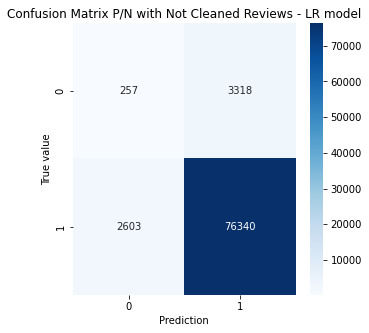

In [ ]:
import seaborn as sn
import matplotlib.pyplot as plt

def plot_confusion(cm):
  plt.figure(figsize = (5,5))
  sn.heatmap(cm, annot=True, cmap="Blues", fmt='.0f')
  plt.xlabel("Prediction")
  plt.ylabel("True value")
  plt.title("Confusion Matrix P/N with Not Cleaned Reviews - LR model")
  return sn

plot_confusion(confusion_matrix(y_valid, y_pred_lr_pn))

With cleaned and tokenized reviews

In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression

X=df_initial["tokens"].to_list()
y=df_initial["is_good_review"].to_list()

X_train, X_test, y_train, y_test = train_test_split(X, y,
                                                    random_state=0,
                                                    train_size=0.80)

X_valid, X_test, y_valid, y_test = train_test_split(X_test, y_test,
                                                    random_state=0,
                                                    test_size=0.20)

def fit_lr(X_train, y_train):
  model = LogisticRegression()
  model.fit(X_train, y_train)
  return model

freqs_dict = build_freqs(X_train, y_train)


X_train_pn = [text_to_freq(text, freqs_dict) for text in X_train]
X_valid_pn = [text_to_freq(text, freqs_dict) for text in X_valid]
X_test_pn = [text_to_freq(text, freqs_dict) for text in X_test]

model_lr_pn = fit_lr(X_train_pn, y_train)  # model

# check the accuracy

from sklearn.metrics import accuracy_score, f1_score, precision_score
from sklearn.metrics import confusion_matrix


y_pred_lr_pn = model_lr_pn.predict(X_valid_pn)
print("LR Model P/N Frequency_Cleaned Text_Accuracy: {:.2%}".format(accuracy_score(y_valid, y_pred_lr_pn)))
print("LR Model P/N Frequency_Cleaned Text_F_score: {:.2%}".format(f1_score(y_valid, y_pred_lr_pn)))
print("LR Model P/N Frequency_Cleaned Text_Precision: {:.2%}".format(precision_score(y_valid, y_pred_lr_pn)))


LR Model P/N Frequency_Cleaned Text_Accuracy: 92.28%
LR Model P/N Frequency_Cleaned Text_F_score: 95.95%
LR Model P/N Frequency_Cleaned Text_Precision: 96.31%


<module 'seaborn' from '/usr/local/lib/python3.7/dist-packages/seaborn/__init__.py'>

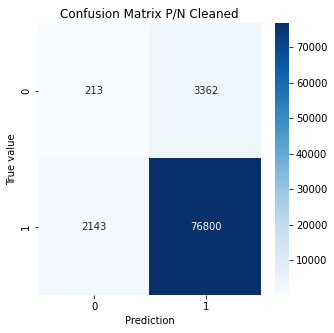

In [ ]:
import seaborn as sn
import matplotlib.pyplot as plt

def plot_confusion(cm):
  plt.figure(figsize = (5,5))
  sn.heatmap(cm, annot=True, cmap="Blues", fmt='.0f')
  plt.xlabel("Prediction")
  plt.ylabel("True value")
  plt.title("Confusion Matrix P/N Cleaned")
  return sn

plot_confusion(confusion_matrix(y_valid, y_pred_lr_pn))

Confusion matrix presents how the binary classification model performs visually. It performs well on a balanced dataset. It is separated to four parts, based on the prediction and actual sentiment value. First section show the TRUE NEGATIVE values (213), when the predicted value and the actual value is negative. On the other size in the opposite box we can see the TRUE POSITIVE values (76 800) when the predicted value and the actual is positive. True positive + true negative = correct prediction by the model. Under true negative box , we can find the FALSE NEGATIVE value(2143) when the actual positive value is predicted as negativ. In the last box we can se the FALSE POSITIVE (3362) values when the prediction positive but truly it is negative. A healthy model has a balanced false negative and false positive proportion that you can see here.

NAIVE BAYES MODEL with POSITIVE/NEGATIVE FREQUENCY vectors

Without cleaned reviews

In [ ]:
from sklearn.naive_bayes import GaussianNB
model=GaussianNB()
model.fit(X_train_pn, y_train)
y_pred=model.predict(X_valid_pn)


print("GaussianNB Model P/N Frequency_Not Cleaned Text_Accuracy: {:.2%}".format(accuracy_score(y_valid, y_pred)))
print("GaussianNB P/N Frequency_Not Cleaned Text_F_score: {:.2%}".format(f1_score(y_valid, y_pred)))
print("GaussianNB P/N Frequency_Not Cleaned Text_Predision: {:.2%}".format(precision_score(y_valid, y_pred)))

GaussianNB Model P/N Frequency_Not Cleaned Text_Accuracy: 92.94%
GaussianNB P/N Frequency_Not Cleaned Text_F_score: 96.32%
GaussianNB P/N Frequency_Not Cleaned Text_Predision: 96.00%


<module 'seaborn' from '/usr/local/lib/python3.7/dist-packages/seaborn/__init__.py'>

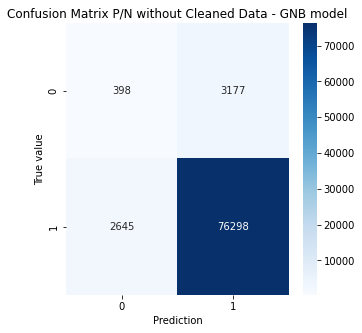

In [ ]:
import seaborn as sn
import matplotlib.pyplot as plt

def plot_confusion(cm):
  plt.figure(figsize = (5,5))
  sn.heatmap(cm, annot=True, cmap="Blues", fmt='.0f')
  plt.xlabel("Prediction")
  plt.ylabel("True value")
  plt.title("Confusion Matrix P/N without Cleaned Data - GNB model")
  return sn

plot_confusion(confusion_matrix(y_valid, y_pred))

With cleaned reviews

In [ ]:
from sklearn.naive_bayes import GaussianNB
model=GaussianNB()
model.fit(X_train_pn, y_train)
y_pred=model.predict(X_valid_pn)

In [ ]:

print("GaussianNB Model P/N Frequency_Cleaned Text_Accuracy: {:.2%}".format(accuracy_score(y_valid, y_pred)))
print("GaussianNB P/N Frequency_Cleaned Text_F_score: {:.2%}".format(f1_score(y_valid, y_pred)))
print("GaussianNB P/N Frequency_Cleaned Text_Predision: {:.2%}".format(precision_score(y_valid, y_pred)))

GaussianNB Model P/N Frequency_Cleaned Text_Accuracy: 92.98%
GaussianNB P/N Frequency_Cleaned Text_F_score: 96.35%
GaussianNB P/N Frequency_Cleaned Text_Predision: 95.96%


<module 'seaborn' from '/usr/local/lib/python3.7/dist-packages/seaborn/__init__.py'>

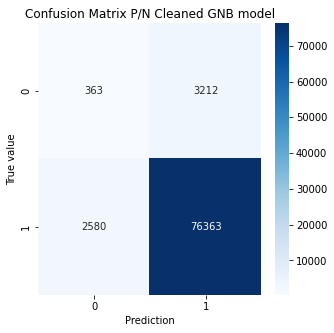

In [ ]:
import seaborn as sn
import matplotlib.pyplot as plt

def plot_confusion(cm):
  plt.figure(figsize = (5,5))
  sn.heatmap(cm, annot=True, cmap="Blues", fmt='.0f')
  plt.xlabel("Prediction")
  plt.ylabel("True value")
  plt.title("Confusion Matrix P/N Cleaned GNB model")
  return sn

plot_confusion(confusion_matrix(y_valid, y_pred))

DECISION TREE MODEL with POSITIVE/NEGATIVE FREQUENCY vectors

Without cleaned and pretokenized reviews

In [ ]:
from sklearn.tree import DecisionTreeClassifier

model=DecisionTreeClassifier(criterion="entropy", random_state=41)
model.fit(X_train_pn, y_train)
y_pred=model.predict(X_valid_pn)

from sklearn.metrics import accuracy_score, f1_score, precision_score
print("Decision Tree Classifier Model_P/N Frequency_Not Cleaned Text_Accuracy: {:.2%}".format(accuracy_score(y_valid, y_pred)))
print("Decision Tree Classifier Model_P/N Frequency_Not Cleaned Text_F_score: {:.2%}".format(f1_score(y_valid, y_pred)))
print("Decision Tree Classifier Model_P/N Frequency_Not Cleaned Text_Precision: {:.2%}".format(precision_score(y_valid, y_pred)))

Decision Tree Classifier Model_P/N Frequency_Not Cleaned Text_Accuracy: 92.07%
Decision Tree Classifier Model_P/N Frequency_Not Cleaned Text_F_score: 95.86%
Decision Tree Classifier Model_P/N Frequency_Not Cleaned Text_Precision: 95.85%


<module 'seaborn' from '/usr/local/lib/python3.7/dist-packages/seaborn/__init__.py'>

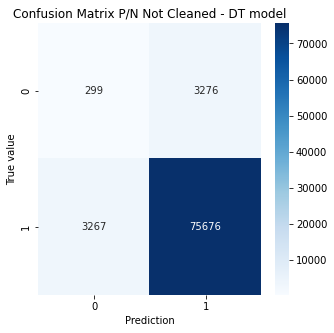

In [ ]:
import seaborn as sn
import matplotlib.pyplot as plt

def plot_confusion(cm):
  plt.figure(figsize = (5,5))
  sn.heatmap(cm, annot=True, cmap="Blues", fmt='.0f')
  plt.xlabel("Prediction")
  plt.ylabel("True value")
  plt.title("Confusion Matrix P/N Not Cleaned - DT model")
  return sn

plot_confusion(confusion_matrix(y_valid, y_pred))

With preCleaned reviews

In [ ]:
from sklearn.tree import DecisionTreeClassifier

model=DecisionTreeClassifier(criterion="entropy", random_state=41)
model.fit(X_train_pn, y_train)
y_pred=model.predict(X_valid_pn)

from sklearn.metrics import accuracy_score, f1_score, precision_score
print("Decision Tree Classifier Model_P/N Frequency_Cleaned Text_Accuracy: {:.2%}".format(accuracy_score(y_valid, y_pred)))
print("Decision Tree Classifier Model_P/N Frequency_Cleaned Text_F_score: {:.2%}".format(f1_score(y_valid, y_pred)))
print("Decision Tree Classifier Model_P/N Frequency_Cleaned Text_Precision: {:.2%}".format(precision_score(y_valid, y_pred)))

Decision Tree Classifier Model_P/N Frequency_Cleaned Text_Accuracy: 92.06%
Decision Tree Classifier Model_P/N Frequency_Cleaned Text_F_score: 95.85%
Decision Tree Classifier Model_P/N Frequency_Cleaned Text_Precision: 95.90%


<module 'seaborn' from '/usr/local/lib/python3.7/dist-packages/seaborn/__init__.py'>

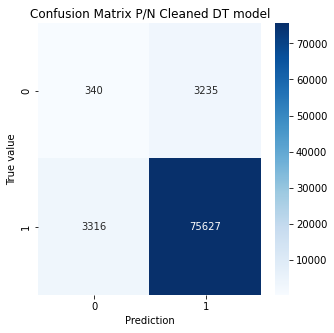

In [ ]:
import seaborn as sn
import matplotlib.pyplot as plt

def plot_confusion(cm):
  plt.figure(figsize = (5,5))
  sn.heatmap(cm, annot=True, cmap="Blues", fmt='.0f')
  plt.xlabel("Prediction")
  plt.ylabel("True value")
  plt.title("Confusion Matrix P/N Cleaned DT model")
  return sn

plot_confusion(confusion_matrix(y_valid, y_pred))

XGBOOST MODEL with POSITIVE/NEGATIVE FREQUENCY vectors

Without precleaned data

In [ ]:
X_train_pn=np.array(X_train_pn)
X_valid_pn=np.array(X_valid_pn)
y_train_pn=np.array(y_train)

In [ ]:
from xgboost import XGBClassifier
model = XGBClassifier()
model.fit(X_train_pn, y_train_pn)
y_pred=model.predict(X_valid_pn)



print("XGBClassifier_P/N Frequency_Without Cleaned Text_Accuracy: {:.2%}".format(accuracy_score(y_valid, y_pred)))
print("XGBClassifier_P/N Frequency_Without Cleaned Text_F_score: {:.2%}".format(f1_score(y_valid, y_pred)))
print("XGBClassifier_P/N Frequency_Without Cleaned Text_Precision: {:.2%}".format(precision_score(y_valid, y_pred)))

XGBClassifier_P/N Frequency_Without Cleaned Text_Accuracy: 95.67%
XGBClassifier_P/N Frequency_Without Cleaned Text_F_score: 97.79%
XGBClassifier_P/N Frequency_Without Cleaned Text_Precision: 95.67%


<module 'seaborn' from '/usr/local/lib/python3.7/dist-packages/seaborn/__init__.py'>

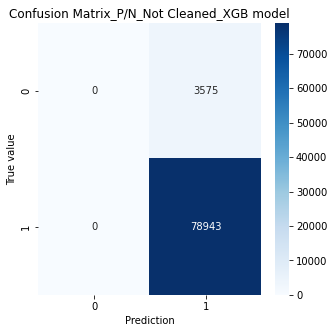

In [ ]:
import seaborn as sn
import matplotlib.pyplot as plt

def plot_confusion(cm):
  plt.figure(figsize = (5,5))
  sn.heatmap(cm, annot=True, cmap="Blues", fmt='.0f')
  plt.xlabel("Prediction")
  plt.ylabel("True value")
  plt.title("Confusion Matrix_P/N_Not Cleaned_XGB model")
  return sn

plot_confusion(confusion_matrix(y_valid, y_pred))

With precleaned data

In [ ]:
X_train_pn=np.array(X_train_pn)
X_valid_pn=np.array(X_valid_pn)
y_train_pn=np.array(y_train)

from xgboost import XGBClassifier
model = XGBClassifier()
model.fit(X_train_pn, y_train)
y_pred=model.predict(X_valid_pn)

from sklearn.metrics import accuracy_score, f1_score, precision_score

print("XGBClassifier_P/N Frequency_With Cleaned Text_Accuracy: {:.2%}".format(accuracy_score(y_valid, y_pred)))
print("XGBClassifier_P/N Frequency_With Cleaned Text_F_score: {:.2%}".format(f1_score(y_valid, y_pred)))
print("XGBClassifier_P/N Frequency_With Cleaned Text_Precision: {:.2%}".format(precision_score(y_valid, y_pred)))

XGBClassifier_P/N Frequency_With Cleaned Text_Accuracy: 95.67%
XGBClassifier_P/N Frequency_With Cleaned Text_F_score: 97.79%
XGBClassifier_P/N Frequency_With Cleaned Text_Precision: 95.67%


<module 'seaborn' from '/usr/local/lib/python3.7/dist-packages/seaborn/__init__.py'>

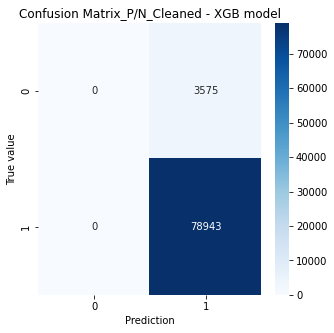

In [ ]:
import seaborn as sn
import matplotlib.pyplot as plt

def plot_confusion(cm):
  plt.figure(figsize = (5,5))
  sn.heatmap(cm, annot=True, cmap="Blues", fmt='.0f')
  plt.xlabel("Prediction")
  plt.ylabel("True value")
  plt.title("Confusion Matrix_P/N_Cleaned - XGB model")
  return sn

plot_confusion(confusion_matrix(y_valid, y_pred))

2.) Sentiment Analysis with BAG OF WORDS

Bag of Words Train_Test Split without Text Cleaning

In [ ]:
from sklearn.model_selection import train_test_split
df_initial

X_train, X_test, y_train, y_test = train_test_split(df_initial.review, df_initial.is_good_review,
                                                    random_state=0,
                                                    train_size=0.80)

Bag of Words Train_Test Split with Text Cleaning

In [ ]:
from sklearn.model_selection import train_test_split
df_initial

X_train, X_test, y_train, y_test = train_test_split(df_initial.tokens, df_initial.is_good_review,
                                                    random_state=0,
                                                    train_size=0.80)



In [ ]:
from sklearn.feature_extraction.text import CountVectorizer

CV=CountVectorizer(lowercase=False)
X_train=CV.fit_transform(X_train)  #create the dictionary from the X_train dataset
X_test=CV.transform(X_test)        # create bag of words on the basis of the dictionary

In [ ]:
feature_names=CV.get_feature_names() # check the dictionary names
len(feature_names)
CV.vocabulary_                      # check the dictionary
feature_names[45000:45010]           # check the dictionary names


In [ ]:
# see a slice of the X_train dataset, if contain any word from the dictionary as the
 # order of the words in dict is the same as the axis=1 of the X_train or X_test

i=45000
j=10
words=CV.get_feature_names()[i:i+10]
pd.DataFrame(X_train[j:j+7, i:i+10].todense(), columns=words)

In [ ]:
# Logistic Regression with Cleaned Text
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, f1_score, precision_score
from sklearn import preprocessing



model = LogisticRegression(solver='lbfgs', max_iter=1000)
model.fit(X_train, y_train)
y_pred=model.predict(X_test)

print("LR Model BoW Cleaned Text Accuracy: {:.2%}".format(accuracy_score(y_test, y_pred)))
print("LR Model BoW Cleaned Text F_score: {:.2%}".format(f1_score(y_test, y_pred)))
print("LR Model BoW Cleaned Text Precision: {:.2%}".format(precision_score(y_test, y_pred)))

LR Model BoW Cleaned Text Accuracy: 96.11%
LR Model BoW Cleaned Text F_score: 97.99%
LR Model BoW Cleaned Text Precision: 96.78%


In [ ]:
#LR with not cleaned

from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, f1_score, precision_score
from sklearn import preprocessing



model = LogisticRegression(solver='lbfgs', max_iter=1000)
model.fit(X_train, y_train)
y_pred=model.predict(X_test)

print("LR Model BoW not Cleaned Text Accuracy: {:.2%}".format(accuracy_score(y_test, y_pred)))
print("LR Model BoW not Cleaned Text F_score: {:.2%}".format(f1_score(y_test, y_pred)))
print("LR Model BoW not Cleaned Text Precision: {:.2%}".format(precision_score(y_test, y_pred)))


LR Model BoW not Cleaned Text Accuracy: 96.14%
LR Model BoW not Cleaned Text F_score: 98.01%
LR Model BoW not Cleaned Text Precision: 96.91%


In [ ]:
# Creating the dictionary and the bag of words matrix for GAUSSIANNB and DECISIONTREE with minimum df=1000

from sklearn.naive_bayes import GaussianNB
from sklearn.feature_extraction.text import CountVectorizer
import numpy as np

CV=CountVectorizer(lowercase=False, min_df=1500)
X_train_np=CV.fit_transform(X_train).toarray()
y_train_np=y_train.to_numpy()
X_test_np=CV.transform(X_test).toarray()

In [ ]:
# Using Naive Bayes model for cleaned and not cleaned text

model=GaussianNB()
model.fit(X_train_np, y_train_np)
y_pred=model.predict(X_test_np)

In [ ]:
#Without Clening

from sklearn.metrics import accuracy_score, f1_score, precision_score

print("GaussianNB Model_BoW_Without Text Cleaning_Accuracy: {:.2%}".format(accuracy_score(y_test, y_pred)))
print("GaussianNB Model_BoW_Without Text Cleaning_F_score: {:.2%}".format(f1_score(y_test, y_pred)))
print("GaussianNB Model_BoW_Without Text Cleaning_Precision: {:.2%}".format(precision_score(y_test, y_pred)))

GaussianNB Model_BoW_Without Text Cleaning_Accuracy: 85.04%
GaussianNB Model_BoW_Without Text Cleaning_F_score: 91.69%
GaussianNB Model_BoW_Without Text Cleaning_Precision: 97.90%


Text(0.5, 1.0, 'Confusion Matrix (GaussianNB, min_df=1000 and no text cleaning)')

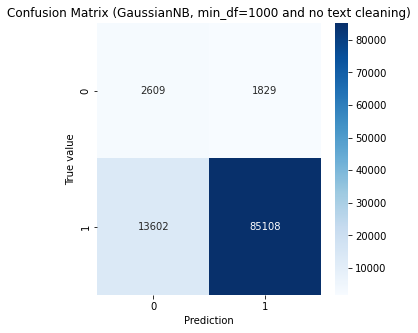

In [ ]:
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
import seaborn as sn

plt.figure(figsize = (5,5))
sn.heatmap(confusion_matrix(y_test, y_pred), annot=True, cmap="Blues", fmt='.0f')
plt.xlabel("Prediction")
plt.ylabel("True value")
plt.title("Confusion Matrix (GaussianNB, min_df=1000 and no text cleaning)", loc='center')

In [ ]:
#With Cleaning

from sklearn.metrics import accuracy_score, f1_score, precision_score

print("GaussianNB Model_BoW_With Cleaned Text_Accuracy: {:.2%}".format(accuracy_score(y_test, y_pred)))
print("GaussianNB Model_BoW_With Cleaned Text_F_score: {:.2%}".format(f1_score(y_test, y_pred)))
print("GaussianNB Model_BoW_With Cleaned Text_Precision: {:.2%}".format(precision_score(y_test, y_pred)))

GaussianNB Model_BoW_With Cleaned Text_Accuracy: 84.25%
GaussianNB Model_BoW_With Cleaned Text_F_score: 91.21%
GaussianNB Model_BoW_With Cleaned Text_Precision: 97.85%


Text(0.5, 1.0, 'Confusion Matrix (GaussianNB, min_df=1000 and with cleaned text)')

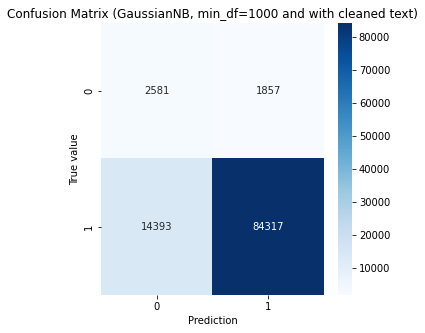

In [ ]:
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
import seaborn as sn

plt.figure(figsize = (5,5))
sn.heatmap(confusion_matrix(y_test, y_pred), annot=True, cmap="Blues", fmt='.0f')
plt.xlabel("Prediction")
plt.ylabel("True value")
plt.title("Confusion Matrix (GaussianNB, min_df=1000 and with cleaned text)", loc='center')

In [ ]:
# Using DecisionTreeClassifier for cleaned and not cleaned text

from sklearn.tree import DecisionTreeClassifier

model=DecisionTreeClassifier(criterion="entropy", random_state=41)
model.fit(X_train_np, y_train_np)
y_pred=model.predict(X_test_np)



In [ ]:
# Without Cleaning

from sklearn.metrics import accuracy_score, f1_score, precision_score
print("Decision Tree Classifier Model_BoW_Without Text Cleaning_Accuracy: {:.2%}".format(accuracy_score(y_test, y_pred)))
print("Decision Tree Classifier Model_BoW_Without Text Cleaning_F_score: {:.2%}".format(f1_score(y_test, y_pred)))
print("Decision Tree Classifier Model_BoW_Without Text Cleaning_Precision: {:.2%}".format(precision_score(y_test, y_pred)))

Decision Tree Classifier Model_BoW_Without Text Cleaning_Accuracy: 93.60%
Decision Tree Classifier Model_BoW_Without Text Cleaning_F_score: 96.65%
Decision Tree Classifier Model_BoW_Without Text Cleaning_Precision: 96.66%


<module 'seaborn' from '/usr/local/lib/python3.7/dist-packages/seaborn/__init__.py'>

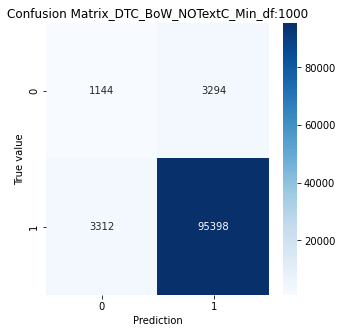

In [ ]:
import seaborn as sn
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix

def plot_confusion(cm):
  plt.figure(figsize = (5,5))
  sn.heatmap(cm, annot=True, cmap="Blues", fmt='.0f')
  plt.xlabel("Prediction")
  plt.ylabel("True value")
  plt.title("Confusion Matrix_DTC_BoW_NOTextC_Min_df:1000")
  return sn

plot_confusion(confusion_matrix(y_test, y_pred))

In [ ]:
#DTC for cleaned dataset

from sklearn.tree import DecisionTreeClassifier

model=DecisionTreeClassifier(criterion="entropy", random_state=41)
model.fit(X_train_np, y_train_np)
y_pred=model.predict(X_test_np)

from sklearn.metrics import accuracy_score, f1_score, precision_score
print("Decision Tree Classifier Model_BoW_Cleaned Text_Accuracy: {:.2%}".format(accuracy_score(y_test, y_pred)))
print("Decision Tree Classifier Model_BoW_Cleaned Text_F_score: {:.2%}".format(f1_score(y_test, y_pred)))
print("Decision Tree Classifier Model_BoW_Cleaned Text_Precision: {:.2%}".format(precision_score(y_test, y_pred)))

Decision Tree Classifier Model_BoW_Cleaned Text_Accuracy: 93.62%
Decision Tree Classifier Model_BoW_Cleaned Text_F_score: 96.66%
Decision Tree Classifier Model_BoW_Cleaned Text_Precision: 96.80%


<module 'seaborn' from '/usr/local/lib/python3.7/dist-packages/seaborn/__init__.py'>

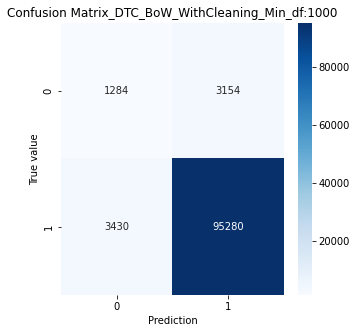

In [ ]:

def plot_confusion(cm):
  plt.figure(figsize = (5,5))
  sn.heatmap(cm, annot=True, cmap="Blues", fmt='.0f')
  plt.xlabel("Prediction")
  plt.ylabel("True value")
  plt.title("Confusion Matrix_DTC_BoW_WithCleaning_Min_df:1000")
  return sn

plot_confusion(confusion_matrix(y_test, y_pred))

In [ ]:
#Uncleaned data
#XGBoost Classifier
from sklearn.feature_extraction.text import CountVectorizer
import numpy as np

CV=CountVectorizer(min_df=2000)
X_train_np=CV.fit_transform(X_train).toarray()
y_train_np=y_train.to_numpy()
X_test_np=CV.transform(X_test).toarray()

from xgboost import XGBClassifier
model = XGBClassifier()
model.fit(X_train_np, y_train_np)
y_pred=model.predict(X_test_np)

from sklearn.metrics import accuracy_score, f1_score, precision_score

print("XGBClassifier_BoW_Without Text Cleaning_Accuracy: {:.2%}".format(accuracy_score(y_test, y_pred)))
print("XGBClassifier_BoW_Without Text Cleaning_F_score: {:.2%}".format(f1_score(y_test, y_pred)))
print("XGBClassifier_BoW_Without Text Cleaning_Precision: {:.2%}".format(precision_score(y_test, y_pred)))

XGBClassifier_BoW_Without Text Cleaning_Accuracy: 95.92%
XGBClassifier_BoW_Without Text Cleaning_F_score: 97.91%
XGBClassifier_BoW_Without Text Cleaning_Precision: 96.01%


<module 'seaborn' from '/usr/local/lib/python3.7/dist-packages/seaborn/__init__.py'>

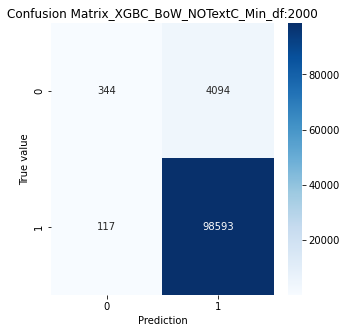

In [ ]:
import seaborn as sn
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix

def plot_confusion(cm):
  plt.figure(figsize = (5,5))
  sn.heatmap(cm, annot=True, cmap="Blues", fmt='.0f')
  plt.xlabel("Prediction")
  plt.ylabel("True value")
  plt.title("Confusion Matrix_XGBC_BoW_NOTextC_Min_df:2000")
  return sn


plot_confusion(confusion_matrix(y_test, y_pred))

In [ ]:
#XGBoost with cleaned text

from sklearn.feature_extraction.text import CountVectorizer
import numpy as np

CV=CountVectorizer(min_df=2000)
X_train_np=CV.fit_transform(X_train).toarray()
y_train_np=y_train.to_numpy()
X_test_np=CV.transform(X_test).toarray()

from xgboost import XGBClassifier
model = XGBClassifier()
model.fit(X_train_np, y_train_np)
y_pred=model.predict(X_test_np)

from sklearn.metrics import accuracy_score, f1_score, precision_score

print("XGBClassifier_BoW_Cleaning_Accuracy: {:.2%}".format(accuracy_score(y_test, y_pred)))
print("XGBClassifier_BoW_Cleaning_F_score: {:.2%}".format(f1_score(y_test, y_pred)))
print("XGBClassifier_BoW_Cleaning_Precision: {:.2%}".format(precision_score(y_test, y_pred)))

XGBClassifier_BoW_Cleaning_Accuracy: 95.94%
XGBClassifier_BoW_Cleaning_F_score: 97.92%
XGBClassifier_BoW_Cleaning_Precision: 96.02%


<module 'seaborn' from '/usr/local/lib/python3.7/dist-packages/seaborn/__init__.py'>

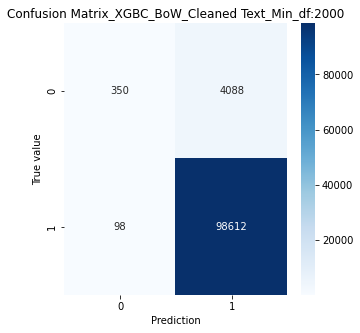

In [ ]:
def plot_confusion(cm):
  plt.figure(figsize = (5,5))
  sn.heatmap(cm, annot=True, cmap="Blues", fmt='.0f')
  plt.xlabel("Prediction")
  plt.ylabel("True value")
  plt.title("Confusion Matrix_XGBC_BoW_Cleaned Text_Min_df:2000")
  return sn


plot_confusion(confusion_matrix(y_test, y_pred))

3.) Sentiment Analysis with TF-IDF (Term Frequency - Inverse Document Frequency)

Linear Regression model
Train test split for not cleaned data

In [ ]:
from sklearn.model_selection import train_test_split
df_initial

X_train, X_test, y_train, y_test = train_test_split(df_initial.review, df_initial.is_good_review,
                                                    random_state=0,
                                                    train_size=0.80)

Train test split for cleaned data

In [ ]:
from sklearn.model_selection import train_test_split
df_initial

X_train, X_test, y_train, y_test = train_test_split(df_initial.tokens, df_initial.is_good_review,
                                                    random_state=0,
                                                    train_size=0.80)

In [ ]:
from sklearn.feature_extraction.text import TfidfVectorizer

vectorizer = TfidfVectorizer(lowercase=False)
X_train = vectorizer.fit_transform(X_train)
X_test=vectorizer.transform(X_test)


In [ ]:
#for not cleaned dataset

from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, f1_score, precision_score
from sklearn import preprocessing



model = LogisticRegression(solver='lbfgs', max_iter=1000)
model.fit(X_train, y_train)
y_pred=model.predict(X_test)

print("LR Model TFIDF not Cleaned Text Accuracy: {:.2%}".format(accuracy_score(y_test, y_pred)))
print("LR Model TFIDF not Cleaned Text F_score: {:.2%}".format(f1_score(y_test, y_pred)))
print("LR Model TFIDF not Cleaned Text Precision: {:.2%}".format(precision_score(y_test, y_pred)))

LR Model TFIDF not Cleaned Text Accuracy: 96.22%
LR Model TFIDF not Cleaned Text F_score: 98.05%
LR Model TFIDF not Cleaned Text Precision: 96.62%


In [ ]:
#for cleaned dataset
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, f1_score, precision_score
from sklearn import preprocessing



model = LogisticRegression(solver='lbfgs', max_iter=1000)
model.fit(X_train, y_train)
y_pred=model.predict(X_test)

print("LR Model TFIDF Cleaned Text Accuracy: {:.2%}".format(accuracy_score(y_test, y_pred)))
print("LR Model TFIDF Cleaned Text F_score: {:.2%}".format(f1_score(y_test, y_pred)))
print("LR Model TFIDF Cleaned Text Precision: {:.2%}".format(precision_score(y_test, y_pred)))


LR Model TFIDF Cleaned Text Accuracy: 96.22%
LR Model TFIDF Cleaned Text F_score: 98.05%
LR Model TFIDF Cleaned Text Precision: 96.64%


Naive BAYES Model

In [ ]:
from sklearn.naive_bayes import GaussianNB
from sklearn.feature_extraction.text import CountVectorizer
import numpy as np

vectorizer = TfidfVectorizer(lowercase=False, min_df=1500)
X_train_np = vectorizer.fit_transform(X_train).toarray()
y_train_np=y_train.to_numpy()
X_test_np=vectorizer.transform(X_test).toarray()



In [ ]:
model=GaussianNB()
model.fit(X_train_np, y_train_np)
y_pred=model.predict(X_test_np)

In [ ]:
#cleaned
from sklearn.metrics import accuracy_score, f1_score, precision_score

print("GaussianNB Model_TFIDF_Cleaned Text_Accuracy: {:.2%}".format(accuracy_score(y_test, y_pred)))
print("GaussianNB Model_TFIDF_Cleaned Text_F_score: {:.2%}".format(f1_score(y_test, y_pred)))
print("GaussianNB Model_TFIDF_Cleaned Text_Precision: {:.2%}".format(precision_score(y_test, y_pred)))

GaussianNB Model_TFIDF_Cleaned Text_Accuracy: 70.70%
GaussianNB Model_TFIDF_Cleaned Text_F_score: 82.06%
GaussianNB Model_TFIDF_Cleaned Text_Precision: 99.05%


In [ ]:
#not cleaned

model=GaussianNB()
model.fit(X_train_np, y_train_np)
y_pred=model.predict(X_test_np)

from sklearn.metrics import accuracy_score, f1_score, precision_score

print("GaussianNB Model_TFIDF_Without Text Cleaning_Accuracy: {:.2%}".format(accuracy_score(y_test, y_pred)))
print("GaussianNB Model_TFIDF_Without Text Cleaning_F_score: {:.2%}".format(f1_score(y_test, y_pred)))
print("GaussianNB Model_TFIDF_Without Text Cleaning_Precision: {:.2%}".format(precision_score(y_test, y_pred)))

GaussianNB Model_TFIDF_Without Text Cleaning_Accuracy: 69.70%
GaussianNB Model_TFIDF_Without Text Cleaning_F_score: 81.32%
GaussianNB Model_TFIDF_Without Text Cleaning_Precision: 99.12%


Decision Tree Classifier

In [ ]:
#cleaned

from sklearn.tree import DecisionTreeClassifier

model=DecisionTreeClassifier(criterion="entropy", random_state=41)
model.fit(X_train_np, y_train_np)
y_pred=model.predict(X_test_np)



from sklearn.metrics import accuracy_score, f1_score, precision_score
print("Decision Tree Classifier Model_TFIDF_Cleaned Text_Accuracy: {:.2%}".format(accuracy_score(y_test, y_pred)))
print("Decision Tree Classifier Model_TFIDF_Cleaned Text_F_score: {:.2%}".format(f1_score(y_test, y_pred)))
print("Decision Tree Classifier Model_TFIDF_Cleaned Text_Precision: {:.2%}".format(precision_score(y_test, y_pred)))

Decision Tree Classifier Model_TFIDF_Cleaned Text_Accuracy: 94.06%
Decision Tree Classifier Model_TFIDF_Cleaned Text_F_score: 96.90%
Decision Tree Classifier Model_TFIDF_Cleaned Text_Precision: 96.70%


In [ ]:
# Without Cleaning

from sklearn.tree import DecisionTreeClassifier

model=DecisionTreeClassifier(criterion="entropy", random_state=41)
model.fit(X_train_np, y_train_np)
y_pred=model.predict(X_test_np)



from sklearn.metrics import accuracy_score, f1_score, precision_score
print("Decision Tree Classifier Model_TFIDF_Without Text Cleaning_Accuracy: {:.2%}".format(accuracy_score(y_test, y_pred)))
print("Decision Tree Classifier Model_TFIDF_Without Text Cleaning_F_score: {:.2%}".format(f1_score(y_test, y_pred)))
print("Decision Tree Classifier Model_TFIDF_Without Text Cleaning_Precision: {:.2%}".format(precision_score(y_test, y_pred)))

Decision Tree Classifier Model_TFIDF_Without Text Cleaning_Accuracy: 93.71%
Decision Tree Classifier Model_TFIDF_Without Text Cleaning_F_score: 96.72%
Decision Tree Classifier Model_TFIDF_Without Text Cleaning_Precision: 96.59%


XGBOOST

In [ ]:
#With Cleaned Data
#XGBoost Classifier
from sklearn.feature_extraction.text import TfidfVectorizer
import numpy as np

vectorizer = TfidfVectorizer(lowercase=False, min_df=2500)
X_train_np = vectorizer.fit_transform(X_train).toarray()
y_train_np=y_train.to_numpy()
X_test_np=vectorizer.transform(X_test).toarray()

from xgboost import XGBClassifier
model = XGBClassifier()
model.fit(X_train_np, y_train_np)
y_pred=model.predict(X_test_np)

from sklearn.metrics import accuracy_score, f1_score, precision_score

print("XGBClassifier_TFIDF_Cleaned Text_Accuracy: {:.2%}".format(accuracy_score(y_test, y_pred)))
print("XGBClassifier_TFIDF_Cleaned Text_F_score: {:.2%}".format(f1_score(y_test, y_pred)))
print("XGBClassifier_TFIDF_Cleaned Text_Precision: {:.2%}".format(precision_score(y_test, y_pred)))

XGBClassifier_TFIDF_Cleaned Text_Accuracy: 95.92%
XGBClassifier_TFIDF_Cleaned Text_F_score: 97.91%
XGBClassifier_TFIDF_Cleaned Text_Precision: 95.98%


In [ ]:
#Without cleaning
#XGBoost Classifier
from sklearn.feature_extraction.text import TfidfVectorizer
import numpy as np

vectorizer = TfidfVectorizer(lowercase=False, min_df=2500)
X_train_np = vectorizer.fit_transform(X_train).toarray()
y_train_np=y_train.to_numpy()
X_test_np=vectorizer.transform(X_test).toarray()

from xgboost import XGBClassifier
model = XGBClassifier()
model.fit(X_train_np, y_train_np)
y_pred=model.predict(X_test_np)

from sklearn.metrics import accuracy_score, f1_score, precision_score

print("XGBClassifier_TFIDF_Without Text Cleaning_Accuracy: {:.2%}".format(accuracy_score(y_test, y_pred)))
print("XGBClassifier_TFIDF_Without Text Cleaning_F_score: {:.2%}".format(f1_score(y_test, y_pred)))
print("XGBClassifier_TFIDF_Without Text Cleaning_Precision: {:.2%}".format(precision_score(y_test, y_pred)))

XGBClassifier_TFIDF_Without Text Cleaning_Accuracy: 95.87%
XGBClassifier_TFIDF_Without Text Cleaning_F_score: 97.89%
XGBClassifier_TFIDF_Without Text Cleaning_Precision: 95.94%


4.) Sentiment Analysis with Tensorflow Keras library </br>
NOT CLEANED DATASET

In [ ]:
from sklearn.model_selection import train_test_split

train, test = train_test_split(df_initial, test_size=0.2)
valid_set, test_set=train_test_split(test, test_size=0.3)

In [ ]:
import numpy as np

train_list=train['review'].values.tolist()
valid_list=valid_set['review'].values.tolist()
test_list=test_set['review'].values.tolist()

train_label=train["is_good_review"].values.tolist()
valid_label=valid_set["is_good_review"].values.tolist()
test_label=test_set["is_good_review"].values.tolist()

train_label_np= np.array(train_label, dtype="float32")
valid_label_np= np.array(valid_label, dtype="float32")
test_label_np= np.array(test_label, dtype="float32")

In [ ]:
vocab_size = 10000
embedding_dim = 16
max_length = 100
trunc_type='post'
oov_tok = "<OOV>"


from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

tokenizer = Tokenizer(num_words = vocab_size, oov_token=oov_tok)
tokenizer.fit_on_texts(train_list)
word_index = tokenizer.word_index
sequences = tokenizer.texts_to_sequences(train_list)
padded = pad_sequences(sequences,maxlen=max_length, truncating=trunc_type)

valid_sequences = tokenizer.texts_to_sequences(valid_list)
valid_padded = pad_sequences(valid_sequences,maxlen=max_length)

testing_sequences = tokenizer.texts_to_sequences(test_list)
testing_padded = pad_sequences(testing_sequences,maxlen=max_length)

reverse_word_index = dict([(value, key) for (key, value) in word_index.items()])

def decode_review(text):
    return ' '.join([reverse_word_index.get(i, '?') for i in text])



In [ ]:
#not cleaned but this model not converging

import tensorflow as tf
from tensorflow import keras

import keras.backend as K

def f1_metric(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
    precision = true_positives / (predicted_positives + K.epsilon())
    recall = true_positives / (possible_positives + K.epsilon())
    f1_val = 2*(precision*recall)/(precision+recall+K.epsilon())
    return f1_val

model = tf.keras.Sequential([
    tf.keras.layers.Embedding(vocab_size, embedding_dim, input_length=max_length),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(6, activation='relu'),
    tf.keras.layers.Dense(1, activation='sigmoid')
])
model.compile(loss='binary_crossentropy',optimizer='adam',metrics=['accuracy', f1_metric, tf.keras.metrics.Precision()])
model.summary()

batch_size = 32
num_epochs = 1
model.fit(padded, train_label_np, epochs=num_epochs, batch_size=batch_size, validation_data=(valid_padded, valid_label_np), shuffle=True, verbose=2)

Testing the model on the test set

In [ ]:
predictions = model(testing_padded)

In [ ]:
import numpy


#predictions = predictions.numpy()
test_label_np=test_label_np.tolist()

In [ ]:
predictions

In [ ]:

predictionslist=predictions.numpy()
predictionslist0=[1 if float(x) >= 0.5 else 0 for y in predictionslist for x in y]
predictionslist0=numpy.array(predictionslist0)

In [ ]:
c=numpy.where(predictionslist0==test_label_np)
print('Accuracy on the test set:{:.2%}'.format(len(c[0])/len(test_label_np)))


In [ ]:
import seaborn as sn
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix

def plot_confusion(cm):
  plt.figure(figsize = (5,5))
  sn.heatmap(cm, annot=True, cmap="Blues", fmt='.0f')
  plt.xlabel("Prediction")
  plt.ylabel("True value")
  plt.title("Confusion Matrix")
  return sn

plot_confusion(confusion_matrix(test_label_np, predictionslist0))

Insert Conv1D and GlobalAveragePooling into the model to dampen the overfitting

In [ ]:
import tensorflow as tf
from tensorflow import keras

import keras.backend as K

def f1_metric(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
    precision = true_positives / (predicted_positives + K.epsilon())
    recall = true_positives / (possible_positives + K.epsilon())
    f1_val = 2*(precision*recall)/(precision+recall+K.epsilon())
    return f1_val

model = tf.keras.Sequential([
    tf.keras.layers.Embedding(vocab_size, embedding_dim, input_length=max_length),
    tf.keras.layers.Conv1D(128, 5, activation='relu'),
    tf.keras.layers.GlobalAveragePooling1D(),
    tf.keras.layers.Dense(6, activation='relu'),
    tf.keras.layers.Dense(1, activation='sigmoid')
])
model.compile(loss='binary_crossentropy',optimizer='adam',metrics=['accuracy', f1_metric, tf.keras.metrics.Precision()])
model.summary()

batch_size = 32
num_epochs = 5
model.fit(padded, train_label_np, epochs=num_epochs, batch_size=batch_size, validation_data=(valid_padded, valid_label_np), shuffle=True, verbose=2)

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_3 (Embedding)      (None, 100, 16)           160000    
_________________________________________________________________
conv1d_3 (Conv1D)            (None, 96, 128)           10368     
_________________________________________________________________
global_average_pooling1d_3 ( (None, 128)               0         
_________________________________________________________________
dense_6 (Dense)              (None, 6)                 774       
_________________________________________________________________
dense_7 (Dense)              (None, 1)                 7         
Total params: 171,149
Trainable params: 171,149
Non-trainable params: 0
_________________________________________________________________
Epoch 1/5
12894/12894 - 1231s - loss: 0.1175 - accuracy: 0.9594 - f1_metric: 0.9788 - precision_3: 0.9624 - val_lo

In [ ]:
predictions = model(testing_padded)

In [ ]:
import numpy


#predictions = predictions.numpy()
#test_label_np=test_label_np.tolist()


predictionslist=predictions.numpy()
predictionslist0=[1 if float(x) > 0.5 else 0 for y in predictionslist for x in y]
predictionslist0=numpy.array(predictionslist0)

In [ ]:
c=numpy.where(predictionslist0==test_label_np)
print('Accuracy on the test set:{:.2%}'.format(len(c[0])/len(test_label_np)))

Accuracy on the test set:96.30%


<module 'seaborn' from '/usr/local/lib/python3.7/dist-packages/seaborn/__init__.py'>

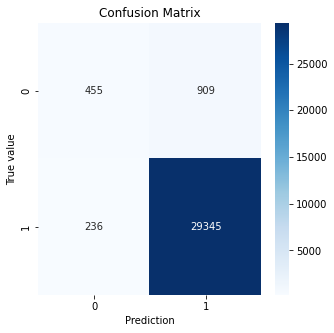

In [ ]:
import seaborn as sn
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix

def plot_confusion(cm):
  plt.figure(figsize = (5,5))
  sn.heatmap(cm, annot=True, cmap="Blues", fmt='.0f')
  plt.xlabel("Prediction")
  plt.ylabel("True value")
  plt.title("Confusion Matrix")
  return sn

plot_confusion(confusion_matrix(test_label_np, predictionslist0))

LSTM MODEL

In [ ]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.layers import LSTM

import keras.backend as K

def f1_metric(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
    precision = true_positives / (predicted_positives + K.epsilon())
    recall = true_positives / (possible_positives + K.epsilon())
    f1_val = 2*(precision*recall)/(precision+recall+K.epsilon())
    return f1_val

model2 = tf.keras.Sequential([
    tf.keras.layers.Embedding(vocab_size, embedding_dim, input_length=max_length),
    tf.keras.layers.Bidirectional(LSTM(150)),
    tf.keras.layers.Dense(6, activation='relu'),
    tf.keras.layers.Dense(1, activation='sigmoid')
])
model2.compile(loss='binary_crossentropy',optimizer='adam',metrics=['accuracy', f1_metric, tf.keras.metrics.Precision()])
model2.summary()

batch_size = 32
num_epochs = 5
model2.fit(padded, train_label_np, epochs=num_epochs, batch_size=batch_size, validation_data=(valid_padded, valid_label_np), shuffle=True, verbose=2)

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_4 (Embedding)      (None, 100, 16)           160000    
_________________________________________________________________
bidirectional_2 (Bidirection (None, 300)               200400    
_________________________________________________________________
dense_6 (Dense)              (None, 6)                 1806      
_________________________________________________________________
dense_7 (Dense)              (None, 1)                 7         
Total params: 362,213
Trainable params: 362,213
Non-trainable params: 0
_________________________________________________________________
Epoch 1/5
12894/12894 - 4776s - loss: 0.1210 - accuracy: 0.9598 - f1_metric: 0.9790 - precision_3: 0.9628 - val_loss: 0.1048 - val_accuracy: 0.9634 - val_f1_metric: 0.9809 - val_precision_3: 0.9650
Epoch 2/5
12894/12894 - 4853s - loss: 0.1000 - a

Neural network wit conv1D and LSTM on CLEANED DATASET

In [ ]:
import numpy as np

train_list=train['tokens'].values.tolist()
valid_list=valid_set['tokens'].values.tolist()
test_list=test_set['tokens'].values.tolist()

train_label=train["is_good_review"].values.tolist()
valid_label=valid_set["is_good_review"].values.tolist()
test_label=test_set["is_good_review"].values.tolist()

train_label_np= np.array(train_label, dtype="float32")
valid_label_np= np.array(valid_label, dtype="float32")
test_label_np= np.array(test_label, dtype="float32")

vocab_size = 10000
embedding_dim = 16
max_length = 100
trunc_type='post'
oov_tok = "<OOV>"


from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

tokenizer = Tokenizer(num_words = vocab_size, oov_token=oov_tok)
tokenizer.fit_on_texts(train_list)
word_index = tokenizer.word_index
sequences = tokenizer.texts_to_sequences(train_list)
padded = pad_sequences(sequences,maxlen=max_length, truncating=trunc_type)

valid_sequences = tokenizer.texts_to_sequences(valid_list)
valid_padded = pad_sequences(valid_sequences,maxlen=max_length)

testing_sequences = tokenizer.texts_to_sequences(test_list)
testing_padded = pad_sequences(testing_sequences,maxlen=max_length)

reverse_word_index = dict([(value, key) for (key, value) in word_index.items()])

def decode_review(text):
    return ' '.join([reverse_word_index.get(i, '?') for i in text])


In [ ]:
import tensorflow as tf
from tensorflow import keras

import keras.backend as K

def f1_metric(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
    precision = true_positives / (predicted_positives + K.epsilon())
    recall = true_positives / (possible_positives + K.epsilon())
    f1_val = 2*(precision*recall)/(precision+recall+K.epsilon())
    return f1_val

model = tf.keras.Sequential([
    tf.keras.layers.Embedding(vocab_size, embedding_dim, input_length=max_length),
    tf.keras.layers.Conv1D(128, 5, activation='relu'),
    tf.keras.layers.GlobalAveragePooling1D(),
    tf.keras.layers.Dense(6, activation='relu'),
    tf.keras.layers.Dense(1, activation='sigmoid')
])
model.compile(loss='binary_crossentropy',optimizer='adam',metrics=['accuracy', f1_metric, tf.keras.metrics.Precision()])
model.summary()

batch_size = 32
num_epochs = 5
model.fit(padded, train_label_np, epochs=num_epochs, batch_size=batch_size, validation_data=(valid_padded, valid_label_np), shuffle=True, verbose=2)

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 100, 16)           160000    
_________________________________________________________________
conv1d (Conv1D)              (None, 96, 128)           10368     
_________________________________________________________________
global_average_pooling1d (Gl (None, 128)               0         
_________________________________________________________________
dense (Dense)                (None, 6)                 774       
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 7         
Total params: 171,149
Trainable params: 171,149
Non-trainable params: 0
_________________________________________________________________
Epoch 1/5
12894/12894 - 214s - loss: 0.1157 - accuracy: 0.9602 - f1_metric: 0.9792 - precision: 0.9640 - val_loss: 0

In [ ]:
predictions = model(testing_padded)

import numpy


#predictions = predictions.numpy()
#test_label_np=test_label_np.tolist()


predictionslist=predictions.numpy()
predictionslist0=[1 if float(x) > 0.5 else 0 for y in predictionslist for x in y]
predictionslist0=numpy.array(predictionslist0)

c=numpy.where(predictionslist0==test_label_np)
print('Accuracy on the test set:{:.2%}'.format(len(c[0])/len(test_label_np)))

Accuracy on the test set:96.20%


<module 'seaborn' from '/usr/local/lib/python3.7/dist-packages/seaborn/__init__.py'>

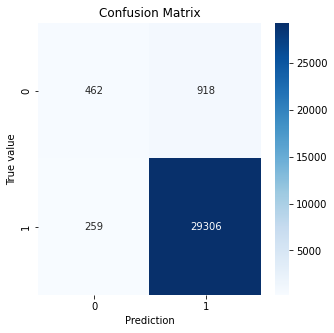

In [ ]:
import seaborn as sn
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix

def plot_confusion(cm):
  plt.figure(figsize = (5,5))
  sn.heatmap(cm, annot=True, cmap="Blues", fmt='.0f')
  plt.xlabel("Prediction")
  plt.ylabel("True value")
  plt.title("Confusion Matrix")
  return sn

plot_confusion(confusion_matrix(test_label_np, predictionslist0))

In [ ]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.layers import LSTM

import keras.backend as K

def f1_metric(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
    precision = true_positives / (predicted_positives + K.epsilon())
    recall = true_positives / (possible_positives + K.epsilon())
    f1_val = 2*(precision*recall)/(precision+recall+K.epsilon())
    return f1_val

model = tf.keras.Sequential([
    tf.keras.layers.Embedding(vocab_size, embedding_dim, input_length=max_length),
    tf.keras.layers.Bidirectional(LSTM(150)),
    tf.keras.layers.Dense(6, activation='relu'),
    tf.keras.layers.Dense(1, activation='sigmoid')
])
model.compile(loss='binary_crossentropy',optimizer='adam',metrics=['accuracy', f1_metric, tf.keras.metrics.Precision()])
model.summary()

batch_size = 32
num_epochs = 5
model.fit(padded, train_label_np, epochs=num_epochs, batch_size=batch_size, validation_data=(valid_padded, valid_label_np), shuffle=True, verbose=2)

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_2 (Embedding)      (None, 100, 16)           160000    
_________________________________________________________________
bidirectional (Bidirectional (None, 300)               200400    
_________________________________________________________________
dense_2 (Dense)              (None, 6)                 1806      
_________________________________________________________________
dense_3 (Dense)              (None, 1)                 7         
Total params: 362,213
Trainable params: 362,213
Non-trainable params: 0
_________________________________________________________________
Epoch 1/5
12894/12894 - 4436s - loss: 0.1095 - accuracy: 0.9615 - f1_metric: 0.9799 - precision_1: 0.9659 - val_loss: 0.1043 - val_accuracy: 0.9629 - val_f1_metric: 0.9806 - val_precision_1: 0.9645
Epoch 2/5
12894/12894 - 4823s - loss: 0.0958 - a

Mini pipeline

In [ ]:
def predict_sentiment(text):
  process_text=process_text(text)
  transformed_text=tf.transform([process_text])
  prediction=model_lr_tf.predict(transformed_text)

  if prediction==1:
    retrun "Prediction is positive sentiment."

  if prediction==0:
    retrun "Prediction is negative sentiment."

